In [1]:
import os
import tqdm
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from utils import check_accuracy_classification
import transformers
from torch.optim import Adam
from models import BertProbeClassifer
from utils import text_to_dataloader, tokenize_word
from bert_embedding import BertEmbeddingExtractor

In [2]:
#%load_ext autoreload
#%autoreload 2

# Data Exploration

In [2]:
train_path = os.path.join("data","en_partut-ud-train.conllu")
dev_path = os.path.join("data","en_partut-ud-dev.conllu")
test_path = os.path.join("data","en_partut-ud-test.conllu")

In [3]:
HEADER_CONST = "# sent_id = "
TEXT_CONST = "# text = "
STOP_CONST = "\n"
WORD_OFFSET = 1
LABEL_OFFSET = 3


def txt_to_dataframe(data_path):
    '''
    read UD text file and convert to df format
    '''
    with open(data_path, "r") as fp:
        df = pd.DataFrame(
            columns={
                "text",
                "word",
                "label"
            }
        )
        for line in fp.readlines():
            if TEXT_CONST in line:
                words_list = []
                labels_list = []
                text = line.split(TEXT_CONST)[1]
                # this is a new text, need to parse all the words in it
            elif line is not STOP_CONST and HEADER_CONST not in line:
                temp_list = line.split("\t")
                words_list.append(temp_list[WORD_OFFSET])
                labels_list.append(temp_list[LABEL_OFFSET])
            if line == STOP_CONST:
                # this is the end of the text, adding to df
                cur_df = pd.DataFrame(
                    {
                        "text": len(words_list) * [text],
                        "word": words_list,
                        "label": labels_list
                    }
                )
                df = pd.concat([df,cur_df])
        return df
            


In [4]:
df_train = txt_to_dataframe(train_path)
df_dev = txt_to_dataframe(dev_path)
df_test = txt_to_dataframe(test_path)

In [5]:
TYPES = [
    "ADJ",
    "ADP",
    "ADV",
    "AUX",
    "CCONJ",
    "DET",
    "INTJ",
    "NOUN",
    "NUM",
    "PART",
    "PRON",
    "PROPN",
    "PUNCT",
    "SCONJ",
    "SYM",
    "VERB",
    "X",
    "_"
]

In [6]:
df_train.sample(5)

,label,text,word
39,PRON,"the Paddington rail crash in London, the terri...",us
25,VERB,"Mr President, we should not forget that the ma...",achieve
21,PUNCT,"Mr President, Commissioner, I would like to be...",.
17,CCONJ,In line with Article 13 of Council Decision of...,and
6,VERB,We look to the Commission to deal with points ...,deal


In [7]:
file_name = 'tex_artifacts/label_dist_train.tex'
SORT_COL = "Count"

with open(file_name,'w') as tf:
    display_df = df_train["label"].value_counts().rename_axis("Type").to_frame("Count").reset_index()
    #display_df.index = TYPES
    display_df.sort_values(by=SORT_COL, inplace=True, ascending=False)
    latex_data = display_df.to_latex(index=False)
    tf.write(latex_data)
    print(display_df.to_markdown(index=False))

| Type   |   Count |
|:-------|--------:|
| NOUN   |    9249 |
| ADP    |    5220 |
| PUNCT  |    5105 |
| DET    |    4616 |
| VERB   |    4126 |
| ADJ    |    3410 |
| AUX    |    2076 |
| PROPN  |    2033 |
| PRON   |    1734 |
| ADV    |    1707 |
| CCONJ  |    1472 |
| PART   |    1168 |
| NUM    |     787 |
| SCONJ  |     627 |
| X      |     140 |
| SYM    |      42 |
| _      |      27 |
| INTJ   |       6 |


In [11]:
file_name = 'tex_artifacts/label_dist_dev.tex'


with open(file_name,'w') as tf:
    display_df = df_dev["label"].value_counts().rename_axis("Type").to_frame("Count").reset_index()
    #display_df.index = TYPES
    display_df.sort_values(by=SORT_COL, inplace=True, ascending=False)
    latex_data = display_df.to_latex(index=False)
    tf.write(latex_data)
    print(display_df.to_markdown(index=False))

| Type   |   Count |
|:-------|--------:|
| NOUN   |     568 |
| PUNCT  |     353 |
| ADP    |     297 |
| VERB   |     276 |
| DET    |     266 |
| ADJ    |     210 |
| PRON   |     153 |
| AUX    |     124 |
| ADV    |     108 |
| PROPN  |     107 |
| CCONJ  |      88 |
| NUM    |      60 |
| PART   |      56 |
| SCONJ  |      41 |
| X      |      13 |
| SYM    |       2 |
| _      |       1 |


In [13]:
file_name = 'tex_artifacts/label_dist_test.tex'


with open(file_name,'w') as tf:
    display_df = df_test["label"].value_counts().rename_axis("Type").to_frame("Count").reset_index()
    #display_df.index = TYPES
    display_df.sort_values(by=SORT_COL, inplace=True, ascending=False)
    latex_data = display_df.to_latex(index=False)
    tf.write(latex_data)
    print(display_df.to_markdown(index=False))

| Type   |   Count |
|:-------|--------:|
| NOUN   |     753 |
| ADP    |     488 |
| DET    |     439 |
| PUNCT  |     339 |
| VERB   |     326 |
| AUX    |     234 |
| ADJ    |     224 |
| ADV    |     131 |
| PRON   |     106 |
| CCONJ  |      96 |
| PROPN  |      90 |
| PART   |      66 |
| NUM    |      61 |
| SCONJ  |      51 |
| _      |       4 |
| INTJ   |       2 |
| X      |       2 |


In [10]:
df_test[df_test["label"] == "VERB"]

,text,word,label
8,Any use of the work other than as authorized u...,authorized,VERB
16,Any use of the work other than as authorized u...,prohibited,VERB
2,UNLESS OTHERWISE AGREED TO BY THE PARTIES IN W...,AGREED,VERB
11,UNLESS OTHERWISE AGREED TO BY THE PARTIES IN W...,OFFERS,VERB
16,UNLESS OTHERWISE AGREED TO BY THE PARTIES IN W...,IS,VERB
...,...,...,...
12,"In the 18th and 19th centuries, his reputation...",spread,VERB
6,Only a small minority of academics believe the...,believe,VERB
8,Only a small minority of academics believe the...,is,VERB
11,Only a small minority of academics believe the...,question,VERB


<AxesSubplot:>

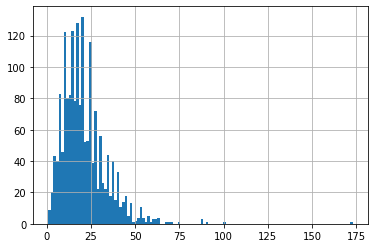

In [24]:
df_train["word_count"] = df_train["text"].apply(lambda x: len(x.split(" ")))
df_train.drop_duplicates(subset="text", keep="first")["word_count"].hist(bins=120)

In [11]:
bert_tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")

In [12]:
df_train, dataloader_train = text_to_dataloader(df_train, "cuda", 32, bert_tokenizer, 256)
df_test, dataloader_test = text_to_dataloader(df_test, "cuda", 32, bert_tokenizer, 256)

In [13]:
file_name = 'tex_artifacts/tokens_per_word_dist_train.tex'

INDEX_AXIS_NAME = "Tokens/Word"
SORT_COL = "Tokens/Word"

with open(file_name,'w') as tf:
    display_df = df_train["query_mask"].apply(lambda x: sum(x)).value_counts().rename_axis(INDEX_AXIS_NAME).to_frame("Count").reset_index()
    display_df.sort_values(by=SORT_COL, inplace=True)
    latex_data = display_df.to_latex(index=False)
    tf.write(latex_data)


In [14]:
# import warnings
# warnings.filterwarnings(action="ignore")


# # extract bert base embedding
# for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
#     bex = BertEmbeddingExtractor(i, "bert-base-uncased")
#     embedding_df = bex.extract_embedding(dataloader_train, "sum")
#     save_path = os.path.join("bert_embeddings", f"bert_base_embedding_layer_{i}")
#     embedding_df.to_csv(save_path, index=False)

In [49]:
import umap

chosen_bert_layer = 12
umap_seed = 42


bert_results_path = os.path.join("bert_embeddings", f"bert_base_embedding_layer_{chosen_bert_layer}")

query_df = pd.read_csv(
    bert_results_path
)

query_df.dropna(inplace=True)

embedding_columns_list = [str(i) for i in list(range(768))]
contextual_embedding_array = query_df[embedding_columns_list].to_numpy()

reducer = umap.UMAP(random_state=umap_seed)
lower_dim_data = reducer.fit_transform(
    contextual_embedding_array,
)

In [52]:
import matplotlib.pyplot as plt
from pylab import cm
import mplcursors

%matplotlib qt

word_list = list(query_df["word"].tolist())
all_labels = query_df["label"].tolist()
labels = list(set(all_labels))
labels.sort()
n_colors = len(labels)

#create new colormap
cmap = cm.get_cmap('tab20', n_colors)

# plot
fig, ax = plt.subplots(figsize=(4.5,4.5))

sc = plt.scatter(
    lower_dim_data[:,0], 
    lower_dim_data[:,1], 
    c=query_df["label_idx"].tolist(),
    cmap=cmap,
    s=1
)

# cursor that show the word when hovering over it
crs = mplcursors.cursor(ax,hover=True)
crs.connect(
    "add", 
    lambda sel: sel.annotation.set_text(
        f"{word_list[sel.target.index]}\n{all_labels[sel.target.index]}"
    ))
    
#title
plt.title(f"{chosen_bert_layer}th layer intermediate representation")

# colorbar
c_ticks = np.arange(n_colors) * (n_colors / (n_colors + 1)) + (2 / n_colors)
cbar = plt.colorbar(sc, ticks=c_ticks)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(labels, ha="right")
cbar.ax.yaxis.set_tick_params(pad=40)
plt.show()

# save figure
name = f"BERT Contextual Embedding Visualization of the {chosen_bert_layer}th Layer"
plt.savefig(name + ".png")